In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.optimize

# USER: Input path for .pkl files
target_dir = "C:\\Users\\fredr\\OneDrive\\Documents\\quail_volcano\\scenarios\\sodtube\\"
# USER: Input path for Quail source code
source_dir = "C:\\Users\\fredr\\OneDrive\\Documents\\quail_volcano\\src\\"

In [2]:
# Import quail modules
os.chdir(source_dir)

import physics.multiphasevpT.multiphasevpT as multiphasevpT
import physics.multiphasevpT.atomics as atomics

import processing.readwritedatafiles as readwritedatafiles
import processing.post as post
import processing.plot as plot
import processing.mdtools as mdtools

import solver.DG as DG
import solver.ADERDG as ADERDG
import solver.tools as solver_tools

import multiprocessing as mp
import multidomain

os.chdir(target_dir)

In [3]:
''' Extract Riemann problem initial condition from file '''

solver0 = readwritedatafiles.read_data_file(f"sodtube_AVnonhydrostatic_p0_0.pkl")
UL = solver0.state_coeffs[0:1,0:1,:]
TL = atomics.temperature(UL[...,0:3], UL[...,3:4], UL[...,4:5], solver0.physics)
phiL = atomics.gas_volfrac(UL[...,0:3], TL, solver0.physics)
pL = atomics.pressure(UL[...,0:3], TL, phiL, solver0.physics)
GammaL = atomics.Gamma(UL[...,0:3], solver0.physics)
rhoL = UL[...,0:3].sum(axis=-1, keepdims=True)
yL = UL[...,0:3] / rhoL
cL = atomics.sound_speed(GammaL, pL, rhoL, phiL, solver0.physics)
uL = UL[...,3:4] / rhoL

UR = solver0.state_coeffs[-1:,-1:,:]
TR = atomics.temperature(UR[...,0:3], UR[...,3:4], UR[...,4:5], solver0.physics)
phiR = atomics.gas_volfrac(UR[...,0:3], TR, solver0.physics)
pR = atomics.pressure(UR[...,0:3], TR, phiR, solver0.physics)
GammaR = atomics.Gamma(UR[...,0:3], solver0.physics)
rhoR = UR[...,0:3].sum(axis=-1, keepdims=True)
yR = UR[...,0:3] / rhoR
cR = atomics.sound_speed(GammaR, pR, rhoR, phiR, solver0.physics)
uR = UR[...,3:4] / rhoR

c:\Users\fredr\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\integrate\_quadrature.py:372: AccuracyWarning: maxiter (50) exceeded. Latest difference = 6.600048e-01
  warnings.warn(
c:\Users\fredr\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\integrate\_quadrature.py:372: AccuracyWarning: maxiter (50) exceeded. Latest difference = 5.106442e-01
  warnings.warn(
c:\Users\fredr\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\integrate\_quadrature.py:372: AccuracyWarning: maxiter (50) exceeded. Latest difference = 3.703708e-01
  warnings.warn(


Text(0, 0.5, 'u_mid (m/s)')

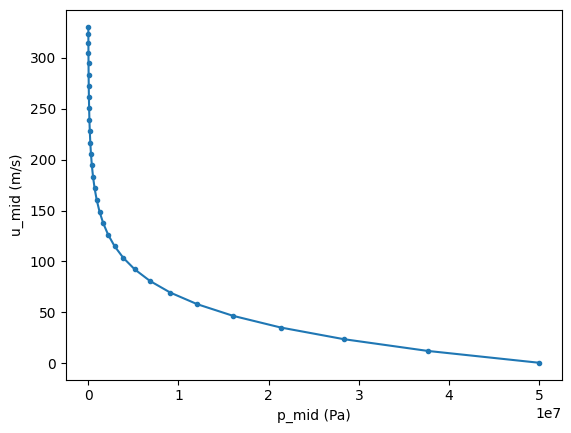

In [4]:
''' Show expansion wave solution with velocity as a function of final expansion pressure '''

# Extract L state, parameters
physics = solver0.physics
arhoVecL = UL[:,:, physics.get_mass_slice()]
volEnergyL = UL[..., physics.get_state_slice("Energy")]
momentumZeros = np.zeros_like(volEnergyL)
K, rho0, p0 = \
  physics.Liquid["K"], physics.Liquid["rho0"], physics.Liquid["p0"]

# Compute L state dependents
T_L = atomics.temperature(arhoVecL, momentumZeros, volEnergyL, physics)
p_L = atomics.pressure(arhoVecL, T_L,
  atomics.gas_volfrac(arhoVecL, T_L, physics), physics)
Gamma = atomics.Gamma(arhoVecL, physics)
S_L = T_L / p_L**((Gamma-1)/Gamma)
y = atomics.massfrac(arhoVecL)
yRGas = y[...,0] * physics.Gas[0]["R"] + y[...,1] * physics.Gas[1]["R"]

def ruT_p(p:float) -> tuple: 
  ''' Compute (rho, u, T) as a function of p, expanding from fixed UL. '''
  normals = np.array([1])
  _, u_expanded, T_expanded = atomics.velocity_RI_fixed_p_quadrature(p, UL[0:1,0:1,:],
    physics, normals, is_adaptive=True, tol=1e-1, rtol=1e-3)
  rho_expanded = 1.0 / atomics.mixture_spec_vol(y, p, T_expanded, physics)
  return float(rho_expanded), float(u_expanded), float(T_expanded)

# Compute density
p_series = np.geomspace(1e4, 50e6, 31)
rho_series = [ruT_p(p)[1] for p in p_series]
plt.plot(p_series, rho_series, '.-')
plt.xlabel("p_mid (Pa)")
plt.ylabel("u_mid (m/s)")

In [5]:
''' Grid-search shock speed sigma, post-shock pressure pP == pE for lowest residual of Rankine-Hugoniot momentum & energy conditions. '''
physics = solver0.physics

def compute_RH_residual(sigma, pE, return_norm_only=True):
  ''' Based on guess on shock speed and expanded pressure,
  compute the Rankine-Hugoniot momentum and energy residuals.
  
  Using expanded pressure pE, the expansion wave is computed,
  which gives the velocity uE. The match condition at the contact
  implies (p, u)_P = (p, u)_E. From Rankine-Hugoniot mass, the
  density rho_P is constrained. The residual for the remaining
  Rankine-Hugoniot conditions (momentum, energy) are returned.

  The returned residuals are written in form fP / fR - 1, where
  fP is the flux on the post-shock side, fR is the flux on the right
  (prescribed) side.
  '''
  # Expanded state Es
  rhoE, uE, TE = ruT_p(pE)
  # Post-shock state P
  uP = uE
  pP = pE
  # Rankine-Hugoniot mass
  rhoP = rhoR * (uR - sigma) / (uP - sigma)
  # Rankine-Hugoniot momentum, residual
  momentumfluxR = rhoR * (uR - sigma)*(uR - sigma) + pR
  momentumfluxP = rhoP * (uP - sigma)*(uP - sigma) + pP

  # Compute rhom(p)
  rhomP = physics.Liquid["rho0"] * (1 + (pP - physics.Liquid["p0"]) / physics.Liquid["K"])
  # Mass fraction vector of post-shock (P) state
  yP = yR.ravel()
  # Mass fraction of magma, post-shock (P) state
  ymP = yP[2]
  # Gas specific volume of post-shock(P) state
  vgasP = (1 / rhoP - ymP /rhomP) / (yP[0] + yP[1])
  # Ideal gas constant of mixed gas
  RgasP = (yP[0] * physics.Gas[0]["R"]
          + yP[1] * physics.Gas[1]["R"]) / (yP[0] + yP[1])
  # Temperature of post-shock (P) state
  TP = pP * vgasP / RgasP
  # Specific energy (per mass) of post-shock (P) state
  eP = float(atomics.c_v(yR, physics)) * TP
  # Specific energy (per mass) of right (R) state
  eR = float(atomics.c_v(yR, physics)) * TR

  # Rankine-Hugoniot energy, residual, divided by mass flux
  energyfluxR = (0.5*(uR - sigma)*(uR - sigma) + eR + pR / rhoR)
  energyfluxP = (0.5*(uP - sigma)*(uP - sigma) + eP + pP / rhoP)

  # Residual vector
  residuals = np.array([(float(momentumfluxP) - float(momentumfluxR)) / (rhoR*cR),
                        (float(energyfluxP) - float(energyfluxR)) / eR])
  if return_norm_only:
    return np.linalg.norm(residuals)
  else:
    return residuals.squeeze()

sigma_range = np.geomspace(cR, 10*cR, 61)
p_range = np.geomspace(pR, 0.5 * (pL + pR), 121)
mg_sigma, mg_p = np.meshgrid(sigma_range, p_range)
mg_residuals = np.zeros_like(mg_sigma)

# Compute RH residuals
mg_residuals.ravel()[:] = np.array(list(map(compute_RH_residual, mg_sigma.ravel(), mg_p.ravel())))

grid search best shock speed: 472.3486614842035 (m/s)
grid search best post-shock pressure: 220545.93482094622 (Pa)


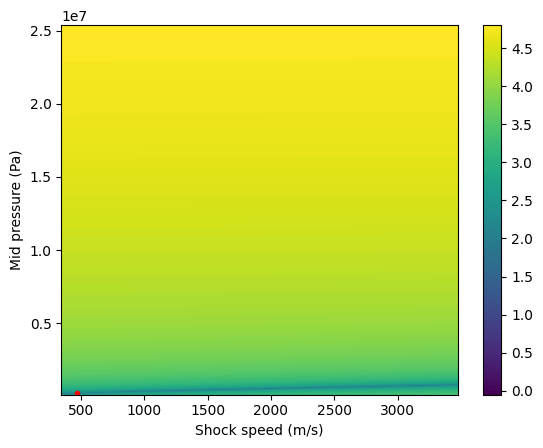

In [6]:
''' Plot norm of Rankine-Hugoniot residuals '''
plt.contourf(mg_sigma, mg_p, np.log10(mg_residuals), levels=200)
plt.colorbar()
plt.xlabel("Shock speed (m/s)")
plt.ylabel("Mid pressure (Pa)")

# Approximate minimizer
_argmin = mg_residuals.ravel().argmin()
_min_sigma, _min_p = mg_sigma.ravel()[_argmin], mg_p.ravel()[_argmin]
plt.plot(_min_sigma, _min_p, 'r.')

print(f"grid search best shock speed: {_min_sigma} (m/s)")
print(f"grid search best post-shock pressure: {_min_p} (Pa)")

In [7]:
''' Use grid search value as initial guess to fsolve '''
(sigma_solve, pP_solve), infodict, ier, mesg = scipy.optimize.fsolve(
  lambda x: compute_RH_residual(x[0], x[1], return_norm_only=False),
  np.array((_min_sigma, _min_p,)),
  full_output=True)
residual_vector = infodict["fvec"]
# Display solved shock speed, post-shock pressure, vector of Rankine-Hugoniot (momentum, energy) residuals
print(f"solved shock speed: {sigma_solve:.3f} m/s")
print(f"solved post-shock pressure: {pP_solve:.3f} Pa")
print(f"root finding fsolve residuals: {residual_vector}")

solved shock speed: 500.867 m/s
solved post-shock pressure: 227391.218 Pa
root finding fsolve residuals: [ 1.016440698272126e-10 -2.840729845415480e-12]


In [8]:
''' Compute expansion wave '''
p_in_expansion = np.linspace(pL, pP_solve, 100).ravel()
rho_in_expansion, u_in_expansion, T_in_expansion = zip(*[ruT_p(p) for p in p_in_expansion])
rho_in_expansion = np.array(rho_in_expansion)
u_in_expansion   = np.array(u_in_expansion)
T_in_expansion   = np.array(T_in_expansion)
# Expand dimensions to (-, -, -)
arhoVec_in_expansion = np.expand_dims(np.array(rho_in_expansion), axis=(1,2))* yL
phi_in_expansion = atomics.gas_volfrac(arhoVec_in_expansion, np.expand_dims(T_in_expansion, axis=(1,2)), physics)
c_in_expansion = atomics.sound_speed(GammaL, np.expand_dims(p_in_expansion, axis=(1,2)),
                                     np.expand_dims(rho_in_expansion, axis=(1,2)),
                                     phi_in_expansion, physics)
# Clean up sound speed
c_in_expansion = c_in_expansion.ravel()

In [9]:
''' Compute post-shock density '''
# Rankine-Hugoniot mass
uP_solved = float(ruT_p(pP_solve)[1])
rhoP = rhoR * (uR - sigma_solve) / (uP_solved - sigma_solve)
rhoP = float(rhoP)

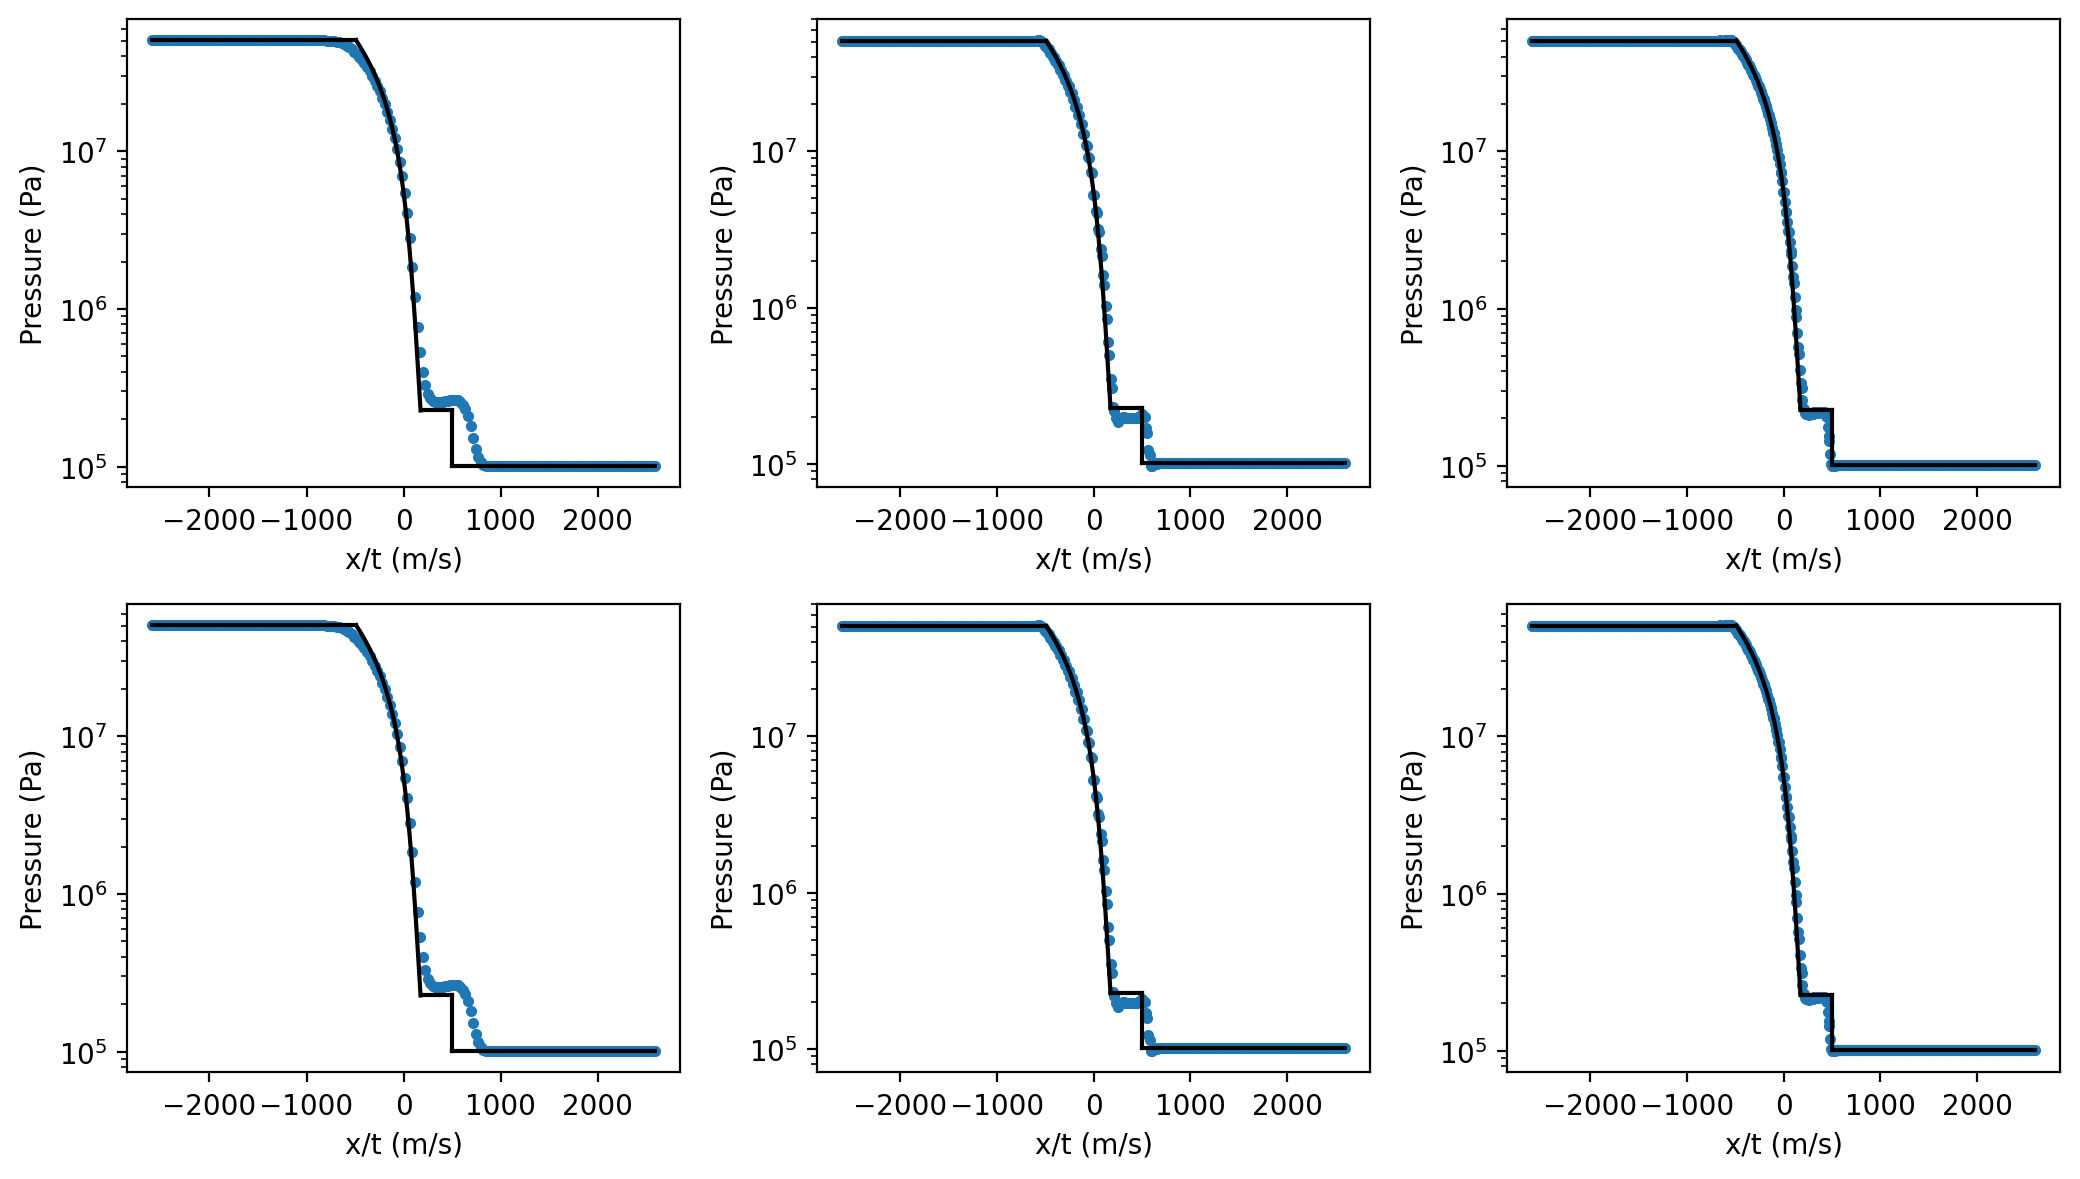

In [14]:
''' Plot generation '''

plt.figure(figsize=(10.5,6), dpi=200)
solver1D_from = lambda P, i: readwritedatafiles.read_data_file(f"sodtube_AVnonhydrostatic_p{P}_{i}.pkl")

for P in [0, 1, 2]:
  plt.subplot(2,3,P+1)
  # Extract DG solution
  solver = solver1D_from(P, 16)
  t = solver.time
  U = solver.state_coeffs
  x = solver.elem_helpers.x_elems
  p = solver.physics.compute_variable("Pressure", U)
  rho = U[...,0:3].sum(axis=-1)
  # Select plot tool
  plot_tool = lambda *args: plt.semilogy(*args)
  # Plot DG solution at nodes
  plot_tool(x.ravel()/t, p.ravel(), '.')

  ''' Exact solution '''
  # Plot pre-expansion wave
  x_min_expanded = (u_in_expansion - c_in_expansion)[0]
  x_preexpansion = np.linspace((x.ravel()/t).min(), x_min_expanded, 2)
  plot_tool(x_preexpansion, float(pL) * np.ones_like(x_preexpansion), 'k-')
  # Plot expansion wave
  plot_tool(u_in_expansion - c_in_expansion, p_in_expansion, 'k-')
  # Plot post-shock position
  x_max_expanded = (u_in_expansion - c_in_expansion)[-1]
  x_postshock = np.linspace(x_max_expanded, sigma_solve, 2)
  plot_tool(x_postshock, pP_solve * np.ones_like(x_postshock), 'k-')
  # Plot shock connector (vertical line)
  plot_tool([sigma_solve, sigma_solve], [float(pR), pP_solve], 'k-')
  # Plot pre-shock
  x_preshock = np.linspace(sigma_solve, (x.ravel()/t).max(), 2)
  plot_tool(x_preshock, float(pR) * np.ones_like(x_preshock), 'k-')

  # Labeling
  plt.xlabel("x/t (m/s)")
  plt.ylabel("Pressure (Pa)")

  plt.subplot(2,3,3+P+1)
  # Extract DG solution
  solver = solver1D_from(P, 16)
  t = solver.time
  U = solver.state_coeffs
  x = solver.elem_helpers.x_elems
  rho = U[...,0:3].sum(axis=-1, keepdims=True)
  # Select plot tool
  plot_tool = lambda *args: plt.semilogy(*args)
  # Plot DG solution at nodes
  plot_tool(x.ravel()/t, rho.ravel(), '.')

  ''' Exact solution '''
  # Plot pre-expansion wave
  x_min_expanded = (u_in_expansion - c_in_expansion)[0]
  x_preexpansion = np.linspace((x.ravel()/t).min(), x_min_expanded, 2)
  plot_tool(x_preexpansion, float(rhoL) * np.ones_like(x_preexpansion), 'k-')
  # Plot expansion wave
  plot_tool(u_in_expansion - c_in_expansion, rho_in_expansion, 'k-')
  # Plot material interface connector (vertical line)
  plot_tool((u_in_expansion - c_in_expansion).ravel()[-1] * np.array([1, 1]),
            [rho_in_expansion.ravel()[-1], float(rhoP)], 'k:')
  # Plot post-shock position
  x_max_expanded = (u_in_expansion - c_in_expansion)[-1]
  x_postshock = np.linspace(x_max_expanded, sigma_solve, 2)
  plot_tool(x_postshock, rhoP * np.ones_like(x_postshock), 'k-')
  # Plot shock connector (vertical line)
  plot_tool([sigma_solve, sigma_solve], [float(rhoR), rhoP], 'k-')
  # Plot pre-shock
  x_preshock = np.linspace(sigma_solve, (x.ravel()/t).max(), 2)
  plot_tool(x_preshock, float(rhoR) * np.ones_like(x_preshock), 'k-')

  # Labeling
  plt.xlabel("$x/t$ (m/s)")
  plt.ylabel("Density (kg/m${}^3$)")

  ax2 = plt.gca().twinx()
  ax2.plot(x.ravel()/t, (U[...,0:1]/rho).ravel(), '^', color="#ad0a20", markersize=2.5)
  ax2.set_ylabel("$y_\mathrm{a}$")

plt.tight_layout()

plt.savefig('combined_sodproblem.eps', format='eps')
plt.savefig('combined_sodproblem.svg', format='svg')

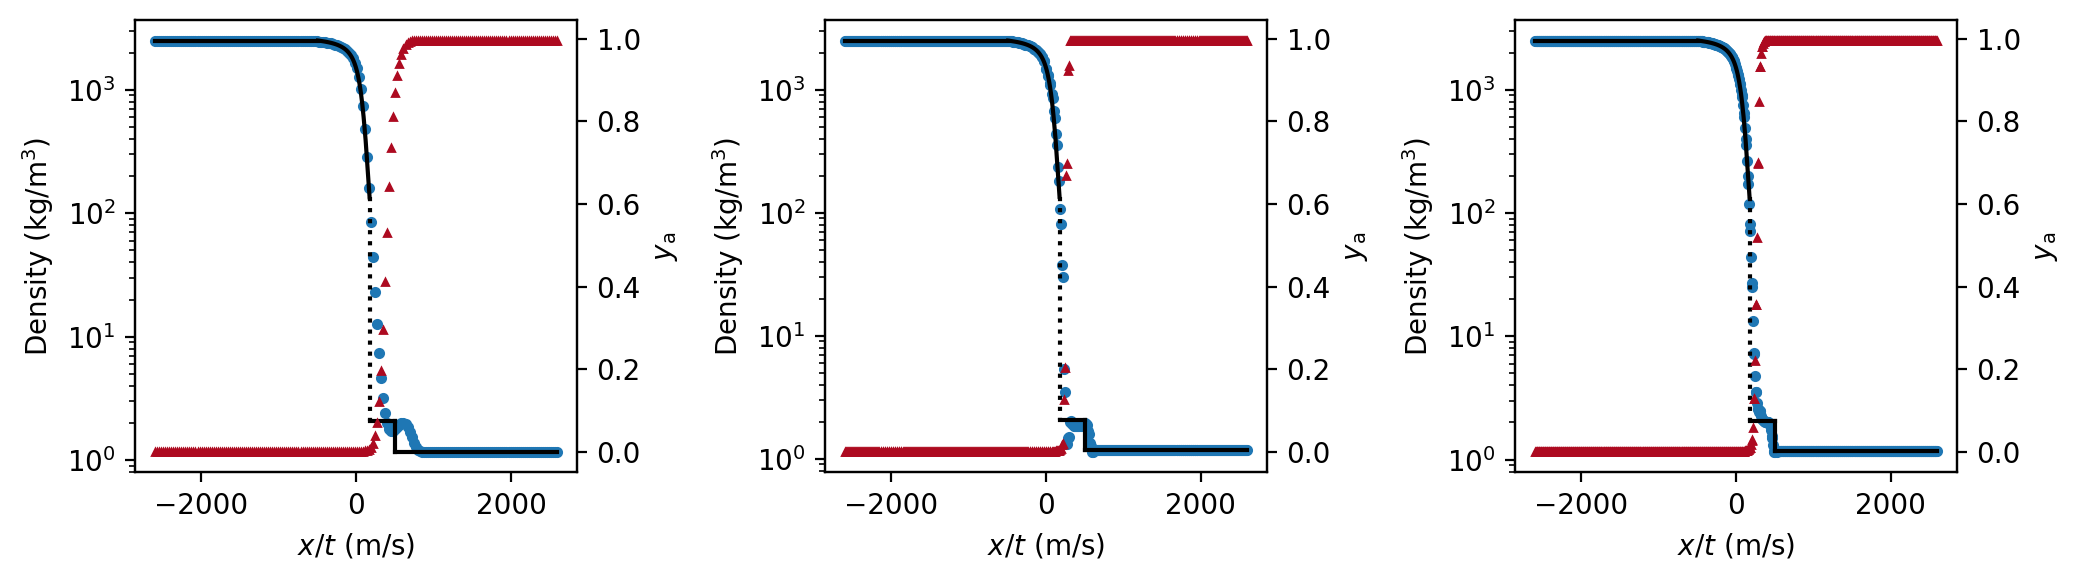

In [11]:
''' Plot generation '''

plt.figure(figsize=(10.5,3), dpi=200)
# Extract DG solution
solver1D_from = lambda P, i: readwritedatafiles.read_data_file(f"sodtube_AVnonhydrostatic_p{P}_{i}.pkl")

for P in [0, 1, 2]:
  plt.subplot(1,3,P+1)
  solver = solver1D_from(P, 16)
  t = solver.time
  U = solver.state_coeffs
  x = solver.elem_helpers.x_elems
  rho = U[...,0:3].sum(axis=-1, keepdims=True)
  # Select plot tool
  plot_tool = lambda *args: plt.semilogy(*args)
  # Plot DG solution at nodes
  plot_tool(x.ravel()/t, rho.ravel(), '.')

  ''' Exact solution '''
  # Plot pre-expansion wave
  x_min_expanded = (u_in_expansion - c_in_expansion)[0]
  x_preexpansion = np.linspace((x.ravel()/t).min(), x_min_expanded, 2)
  plot_tool(x_preexpansion, float(rhoL) * np.ones_like(x_preexpansion), 'k-')
  # Plot expansion wave
  plot_tool(u_in_expansion - c_in_expansion, rho_in_expansion, 'k-')
  # Plot material interface connector (vertical line)
  plot_tool((u_in_expansion - c_in_expansion).ravel()[-1] * np.array([1, 1]),
            [rho_in_expansion.ravel()[-1], float(rhoP)], 'k:')
  # Plot post-shock position
  x_max_expanded = (u_in_expansion - c_in_expansion)[-1]
  x_postshock = np.linspace(x_max_expanded, sigma_solve, 2)
  plot_tool(x_postshock, rhoP * np.ones_like(x_postshock), 'k-')
  # Plot shock connector (vertical line)
  plot_tool([sigma_solve, sigma_solve], [float(rhoR), rhoP], 'k-')
  # Plot pre-shock
  x_preshock = np.linspace(sigma_solve, (x.ravel()/t).max(), 2)
  plot_tool(x_preshock, float(rhoR) * np.ones_like(x_preshock), 'k-')

  # Labeling
  plt.xlabel("$x/t$ (m/s)")
  plt.ylabel("Density (kg/m${}^3$)")

  ax2 = plt.gca().twinx()
  ax2.plot(x.ravel()/t, (U[...,0:1]/rho).ravel(), '^', color="#ad0a20", markersize=2.5)
  ax2.set_ylabel("$y_\mathrm{a}$")
plt.tight_layout()

plt.savefig('rhoy_sodproblem.eps', format='eps')
plt.savefig('rhoy_sodproblem.svg', format='svg')

In [12]:
''' Compute Mach number '''
M = physics.compute_variable("XVelocity", solver.state_coeffs) / physics.compute_variable("SoundSpeed", solver.state_coeffs)
print(f"max M = {np.abs(M).max()}")

max M = 2.696023227147748
